In [22]:
from PIL import Image
from skimage import filters
from mahotas.features import haralick

import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
import umap.umap_ as UMAP

In [17]:
train_data_zip = 'aksarabali/data/train-original.zip'
test_data_zip = 'aksarabali/data/test.zip'
train_data_aug_zip = 'aksarabali/data/train-augmented.zip'
data_path = 'aksarabali/data/'

def extract_zip(zip_file, output_dir):
	import zipfile
	with zipfile.ZipFile(zip_file, 'r') as zip_ref:
		zip_ref.extractall(output_dir)
		print('Done, extracting {} to {}'.format(zip_file, output_dir))

In [18]:
extract_zip(train_data_zip, data_path)
extract_zip(train_data_aug_zip, data_path)
extract_zip(test_data_zip, data_path)

Done, extracting aksarabali/data/train-original.zip to aksarabali/data/
Done, extracting aksarabali/data/train-augmented.zip to aksarabali/data/
Done, extracting aksarabali/data/test.zip to aksarabali/data/


In [19]:
class Dataset:
    def __init__(self, label_file, image_dir, width=150, height=150):
        csvFile = pd.read_csv(label_file, header=None)
        self.image_dir = image_dir
        self.imagesName = csvFile[0].values
        self.labelsName = csvFile[1].values
        self.labels = csvFile[2].values
        self.height = height
        self.width = width
        
    def __len__(self):
        return len(self.imagesName)
    
    def imgRead(self, index):
        imagePath = os.path.join(self.image_dir, self.imagesName[index])
        imageRGB = Image.open(imagePath).resize((self.height, self.width))
        imageGray = imageRGB.convert(mode="L")
        return np.array(imageRGB), np.array(imageGray)

    def getLabel(self, index):
        return self.labels[index]
    
    def getLabelName(self, index):
        return self.labelsName[index]

    def __getitem__(self, index):
        imRGB, imGray = self.imgRead(index)
        return imRGB, imGray, self.getLabelName(index), self.getLabel(index)

    def getSegmentation(self, index):
        _, imageArray = self.imgRead(index)
        thresh = filters.threshold_otsu(imageArray)
        binaryImage = imageArray <= thresh
        return binaryImage  
    
    def getMap(self, index):
        _, imGray = self.imgRead(index)
        return self.getSegmentation(index)*imGray

    def getHaralick(self, index, return_mean=False):
        imageArray = self.getMap(index)
        if return_mean:
            feat = haralick(imageArray, return_mean=True)
        else:
            feat = haralick(imageArray)
            feat = feat.ravel()
        return feat    
    
    def showImg(self, index):
        imRGB, imGray = self.imgRead(index)
        imSeg = self.getSegmentation(index)
        imMap = self.getMap(index)
        lbl = self.getLabel(index)
        lblName = self.getLabelName(index)

        fig, ax = plt.subplots(1, 4)
        fig.suptitle('Index: {}, Class: {}, Label: {}'.format(index, lblName, lbl), y=0.7)
        ax[0].imshow(imRGB)
        ax[0].axis('off')
        ax[1].imshow(imGray, cmap='gray')
        ax[1].axis('off')
        ax[2].imshow(imSeg, cmap='gray')
        ax[2].axis('off')
        ax[3].imshow(imMap, cmap='gray')
        ax[3].axis('off')        
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
        plt.show()


In [20]:
def compare_viz(data, labels, title, dct_pca, dct_tsne, dct_isomap, dct_umap, dct_plot):

    x_pca =  np.expand_dims(PCA(**dct_pca).fit_transform(data), axis=0)
    x_tsne = np.expand_dims(TSNE(**dct_tsne).fit_transform(data), axis=0)
    x_iso =  np.expand_dims(Isomap(**dct_isomap).fit_transform(data), axis=0)
    x_umap = np.expand_dims(UMAP(**dct_umap).fit_transform(data), axis=0)

    transformed_data = np.concatenate((x_pca, x_tsne, x_iso, x_umap), axis=0)

    method_name = ['PCA', 'TSNE', 'Isomap', 'UMAP']
    
    fig, axes = plt.subplots(2,2, figsize=(16,10))
    fig.suptitle('Visualisation in 2-Dimensional Space', fontsize=20)
    for i, ax in enumerate(axes.flat):
        ax.scatter(transformed_data[i,:,0], transformed_data[i,:,1], c=labels, **dct_plot)
        ax.set_title(method_name[i])
    plt.show()

In [25]:
data = Dataset(label_file=os.path.join(data_path, 'train-label-original.csv'), image_dir=os.path.join(data_path, 'train-original'))
# data = Dataset(label_file='train-label-original.csv', image_dir='train-original')

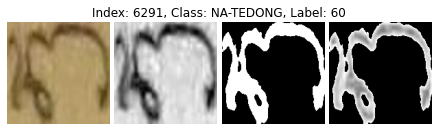

In [27]:
data.showImg(np.random.randint(0,len(data)))

In [32]:


# for i in range (len(data)):
#     feature[i, :] = data.getHaralick(i)
#     label[i, 0] = data.getLabel(i)

# df = np.hstack((feature, label))
# np.savetxt('haralick2.csv', df, delimiter=';', header='')

In [33]:
# pca_param = {'n_components':2}
# plot_para ={'alpha':0.7, 'cmap':'viridis', 'edgecolors':'grey'}

In [34]:
# feature = np.zeros((len(data), 52))
# label = np.zeros((len(data), 1))
# compare_viz(feature, label, 'Haralick', pca_param, pca_param, pca_param, pca_param, plot_para)